<h1 style="font-size:1.5rem;color:orange;">Machine Learning Method Comparison and SHAP Interpretation</h1>

<h2 style="font-size:1rem;color:orange;">Author: Xiaodan Xu, Berkeley Lab (XiaodanXu@lbl.gov),
William Bui, University of California Berkeley </h2>
<h2 style="font-size:1rem;color:orange;"> Last update: Feb 06, 2024 </h2>

# Load Packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
import catboost
import shap
import matplotlib.pyplot as plt
import warnings
# import keras_tuner as kt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
import warnings
warnings.filterwarnings('ignore')

shap.initjs()
plt.style.use('ggplot')

2024-02-06 18:28:01.612449: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Creating Dataframe with CFS Data

In [2]:
# load data
Austin_df = pd.read_csv('data/CFS2017_austin_forML_July2023.csv')
print(Austin_df.columns)

Index(['SHIPMT_ID', 'ORIG_STATE', 'ORIG_MA', 'ORIG_CFS_AREA', 'DEST_STATE',
       'DEST_MA', 'DEST_CFS_AREA', 'NAICS', 'QUARTER', 'SCTG', 'MODE',
       'SHIPMT_VALUE', 'SHIPMT_WGHT', 'SHIPMT_DIST_GC', 'SHIPMT_DIST_ROUTED',
       'TEMP_CNTL_YN', 'EXPORT_YN', 'EXPORT_CNTRY', 'HAZMAT', 'WGT_FACTOR',
       'mode_agg5', 'bulk', 'fuel_fert', 'interm_food', 'mfr_goods', 'other',
       'commodity', 'naics2', 'naics_name', 'wholesale', 'mfring', 'mining',
       'retail', 'info', 'management', 'transwarehouse', 'wght_bin1', 'choice',
       'geo', 'SHIPMT_WGHT_TON', 'value_density', 'SHIPMT_DIST', 'travel_time',
       'ship_cost', 'DIST_BIN', 'WGHT_BIN', 'VAL_DEN_BIN', 'TIME_BIN',
       'COST_BIN'],
      dtype='object')


In [3]:
# Data Cleaning
df_clean = Austin_df.drop(['SHIPMT_ID', 'ORIG_STATE', 'ORIG_MA', 'ORIG_CFS_AREA', 'DEST_STATE', # Removes irrelevant features
                          'DEST_MA', 'DEST_CFS_AREA', 'NAICS', 'SCTG', 'MODE', 'SHIPMT_DIST_ROUTED',
                          'TEMP_CNTL_YN', 'EXPORT_CNTRY', 'WGT_FACTOR', 'mode_agg5',
                          'commodity', 'naics2', 'naics_name', 'SHIPMT_WGHT_TON', 'SHIPMT_DIST_GC', 
                           'QUARTER', 'SHIPMT_VALUE', 'HAZMAT', 'wght_bin1', 'geo', 'DIST_BIN', 'WGHT_BIN', 
                           'VAL_DEN_BIN', 'TIME_BIN', 'COST_BIN'], axis = 1) 

df_clean = df_clean[df_clean.EXPORT_YN == 'N'] # Cleans out international exports
df_clean = df_clean.drop(['EXPORT_YN'], axis = 1)

print(df_clean.columns)
df_clean.describe() 

Index(['SHIPMT_WGHT', 'bulk', 'fuel_fert', 'interm_food', 'mfr_goods', 'other',
       'wholesale', 'mfring', 'mining', 'retail', 'info', 'management',
       'transwarehouse', 'choice', 'value_density', 'SHIPMT_DIST',
       'travel_time', 'ship_cost'],
      dtype='object')


,SHIPMT_WGHT,bulk,fuel_fert,interm_food,mfr_goods,other,wholesale,mfring,mining,retail,info,management,transwarehouse,choice,value_density,SHIPMT_DIST,travel_time,ship_cost
count,2.470730e+05,247073.000000,247073.000000,247073.000000,247073.000000,247073.000000,247073.000000,247073.000000,247073.000000,247073.000000,247073.000000,247073.000000,247073.000000,247073.000000,247073.000000,247073.000000,247073.000000,247073.000000
mean,2.751332e+04,0.112020,0.106458,0.119240,0.593841,0.068441,0.436211,0.425243,0.027032,0.042056,0.012296,0.007629,0.049532,2.886430,71.970159,508.770291,43.372844,269.674656
std,6.875360e+05,0.315391,0.308424,0.324071,0.491116,0.252502,0.495915,0.494381,0.162178,0.200718,0.110204,0.087012,0.216976,0.894892,1633.112301,569.781688,41.569212,755.394401
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000032,1.000000,4.050000,10.000000
25%,1.300000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.720000,30.000000,16.292308,15.000000
50%,2.270000e+02,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.237315,222.000000,20.984615,23.412960
75%,8.130000e+03,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,16.000000,961.000000,67.218750,130.320917
max,3.933640e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,561513.000000,3941.000000,193.409091,27038.655360


In [4]:
# Data Splitting

labels = ['Air', 'For-hire Truck', 'Parcel', 'Private Truck', 'Rail']
features = ['Shipment Weight (lb)', '(CMD) Bulk Goods', 
            '(CMD) Fuel, Fertilizer and Chemicals', 
            '(CMD) Food and Interim Products', '(CMD) Manufactured Products', 
            '(CMD) Other',
            '(IND) Wholesale', '(IND) Manufacturing', '(IND) Mining', 
            '(IND) Retail', '(IND) Information', '(IND) Management', 
            '(IND) Transportation and Warehouse', 'Value Density ($/lb)',
            'Shipment Distance (mi)', 'Travel Time (hr)', 'Shipping Cost ($)']

train = None
test = None

list_of_mode = df_clean['choice'].unique()

# perform stratefied sampling, and get 80%/20% split for each mode
for ch in list_of_mode:
    df_clean_selected = df_clean.loc[df_clean['choice'] == ch]
    train_mode, test_mode = train_test_split(df_clean_selected, 
                                             test_size=0.2, 
                                             random_state=0, 
                                             stratify = df_clean_selected['choice'])
    train = pd.concat([train, train_mode])
    test = pd.concat([test, test_mode])

X_train = train.drop(['choice'], axis = 1)
Y_train = train['choice']-1

X_test = test.drop(['choice'], axis = 1)
Y_test = test['choice']-1

Y_test_reset = Y_test.reset_index()

print(Y_train.unique())

[2 1 4 3 0]


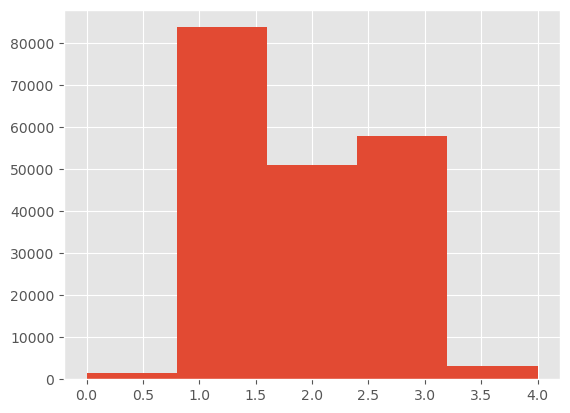

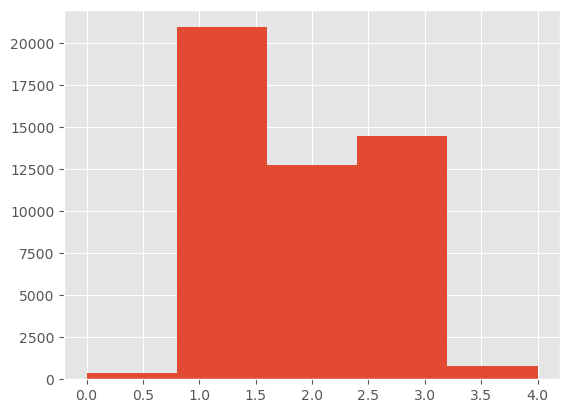

In [5]:
# check mode split in train and test data
Y_train.hist(bins = 5)
plt.show()
Y_test.hist(bins = 5)
plt.show()

# Define Important Functions

In [6]:
def isolateTest(testData_df, classNum): # Isolates test dataset based on a certain mode
    return testData_df[testData_df.choice == classNum].drop(['index'], axis = 1)

def isolatePredictions(testData_df, classNum, predictions_arr): # Isolates prediction dataset based on certain mode
    isolatedTestData = isolateTest(testData_df, classNum)
    
    return predictions_arr[list(isolatedTestData.index.values)]

def printIsolatedAccuracy(testData_df, classNum, predictions_arr, modelName): # Gets accuracy based on isolated prediction and test datasets
    isolatedData = isolateTest(testData_df, classNum).choice
    isolatedPredictions = isolatePredictions(testData_df, classNum, predictions_arr)
    isolatedAccuracy = metrics.accuracy_score(isolatedData, isolatedPredictions)

    print("Mode " + str(classNum) + " " + modelName + " Accuracy: ", isolatedAccuracy)
    
def convertToMode(predictions): # Converts prediction in probability form to mode choice
    convertedPredictions = []
    for prediction in predictions:
        convertedPredictions.append(prediction.argmax())
        
    return convertedPredictions

def plotInteractions(shap_interactions, data, classNum, className): # Plots interaction values
    mean_shap = np.abs(shap_interactions[classNum]).mean(0)
    mean_df = pd.DataFrame(mean_shap,index=data.columns,columns=data.columns)
    
    mean_df.where(mean_df.values == np.diagonal(mean_df), mean_df.values * 2, inplace = True)
    
    plt.figure(figsize=(13, 13), facecolor='w', edgecolor='k')
    sns.set(font_scale=0.7)
    sns.heatmap(mean_df,cmap='coolwarm',annot=True,fmt='.4g',cbar=False).set(title = className + ' Shap Interaction Values')
    plt.yticks(rotation=0) 
    
def plotDependence(classNum, shap_values, data): # Plots dependence plots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))
    axes = axes.ravel()

    delete = 0
    axIndex = 0
    for i, col in enumerate(data.columns):
        if delete < 2 or delete > 13:
            shap.dependence_plot(col, shap_values[classNum], data, 
                                 ax=axes[axIndex], show=False, alpha = 0.2)
            axIndex+=1
        delete+=1

# Random Forest

In [9]:
# parameter tuning for RF
random_forest = RandomForestClassifier(n_estimators = 100) # Random forest model

param_grid = {"max_depth": [3, None],
               'min_samples_split': [2, 6, 10],
              'min_samples_leaf': [1, 3, 4],
             'max_features': ["sqrt", "log2", None]}
search = HalvingGridSearchCV(random_forest, 
                             param_grid, resource='n_estimators',
                             max_resources=10, cv = 10,
                             random_state=0).fit(X_train, Y_train)
print(search.best_params_)
print(search.best_score_)

{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 9}
0.9035141791390331


In [7]:
# hyper-parameter tuned random forest
random_forest_tuned = RandomForestClassifier(n_estimators = 100,
                                            max_depth = None,
                                            min_samples_split = 10,
                                            min_samples_leaf = 1,
                                            max_features = 'log2')
random_forest_tuned.fit(X_train, Y_train)
random_forest_prediction = random_forest_tuned.predict(X_test)

random_forest_tuned

RandomForestClassifier(max_features='log2', min_samples_split=10)

In [8]:
# performance of RF
random_forest_accuracy = metrics.accuracy_score(Y_test, random_forest_prediction) # Random forest accurcy

print("Overall Random Forest Accuracy: ", random_forest_accuracy)
# for x in range(0, 5):
#     printIsolatedAccuracy(Y_test_reset, x, random_forest_prediction, "Random Forest")

# confusion matrix
rf_conf_matrix = confusion_matrix(Y_test, random_forest_prediction)   
print(rf_conf_matrix)

# overall accuracy report
print(classification_report(Y_test, random_forest_prediction))

Overall Random Forest Accuracy:  0.9090393993969687
[[  378     0     0     0     0]
 [    0 18453     0  2511     0]
 [    0     0 12785     0     0]
 [    0  1981     0 12493     0]
 [    0     1     2     0   813]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       378
           1       0.90      0.88      0.89     20964
           2       1.00      1.00      1.00     12785
           3       0.83      0.86      0.85     14474
           4       1.00      1.00      1.00       816

    accuracy                           0.91     49417
   macro avg       0.95      0.95      0.95     49417
weighted avg       0.91      0.91      0.91     49417



# XGBoost

In [12]:
# parameter tuning for XGBoost
xgb_model = XGBClassifier(n_estimators = 100) # XGBoost Model
params = {
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}
search = HalvingGridSearchCV(xgb_model, 
                             params, 
                             resource='n_estimators',
                              max_resources=10, cv = 10,
                             random_state=0).fit(X_train, Y_train)

print(search.best_params_)
print(search.best_score_)

{'base_score': 0.5, 'booster': 'gbtree', 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 1, 'n_estimators': 9}
0.8479985194342745


In [9]:
# hyper-parameter tuned XGBoost
xgb_model_tuned = XGBClassifier(base_score = 0.5,
                                n_estimators = 100, 
                                booster = 'gbtree',
                                learning_rate =  0.1,
                                reg_alpha = 1,
                                reg_lambda = 1) # XGBoost Model
xgb_model_tuned.fit(X_train, Y_train)
xgb_prediction = xgb_model_tuned.predict(X_test)

xgb_model_tuned

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [10]:
xgb_accuracy = metrics.accuracy_score(Y_test, xgb_prediction)

print("Overall XGBoost Accuracy: ", xgb_accuracy)

# for x in range(0, 5):
#     printIsolatedAccuracy(Y_test_reset, x, xgb_prediction, "XGBoost")

# confusion matrix
conf_matrix = confusion_matrix(Y_test, xgb_prediction)   
print(conf_matrix)

# overall accuracy report
print(classification_report(Y_test, xgb_prediction))

Overall XGBoost Accuracy:  0.8749418216403262
[[  378     0     0     0     0]
 [    0 17103     2  3859     0]
 [    0     0 12785     0     0]
 [    0  2316     0 12158     0]
 [    0     0     3     0   813]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       378
           1       0.88      0.82      0.85     20964
           2       1.00      1.00      1.00     12785
           3       0.76      0.84      0.80     14474
           4       1.00      1.00      1.00       816

    accuracy                           0.87     49417
   macro avg       0.93      0.93      0.93     49417
weighted avg       0.88      0.87      0.88     49417



# Catboost

In [12]:
# parameter tuning of CatBoost
catboost_model = catboost.CatBoostClassifier(n_estimators = 100) # Catboost Model
params = {'learning_rate': [0.01, 0.05, 0.1],
          'depth': [4, 6, 10],
          'l2_leaf_reg': [1, 3, 5],
         'min_child_samples': [1, 3, 5, 10],
         'grow_policy': ['SymmetricTree', 'Depthwise']}

search = HalvingGridSearchCV(catboost_model, 
                             params, 
                             resource='n_estimators',
                              max_resources=10, cv = 10,
                             random_state=0).fit(X_train, Y_train)

print(search.best_params_)
print(search.best_score_)

# disabled printing to prevent Catboost provide long verbose
# {'depth': 10, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 1, 
# 'learning_rate': 0.1, 'min_child_samples': 5, 'n_estimators': 9}
# 0.8654378942967401

In [11]:
# hyper-parameter tuned CatBoost
catboost_model_tuned = catboost.CatBoostClassifier(iterations = 300, 
                                             depth = 10,
                                             grow_policy = 'Depthwise',
                                             l2_leaf_reg = 1,
                                             learning_rate = 0.1,
                                             min_child_samples = 5) # Catboost Model
catboost_model_tuned.fit(X_train, Y_train)
catboost_prediction = catboost_model_tuned.predict(X_test)
# catboost_prediction

0:	learn: 1.3272852	total: 168ms	remaining: 50.3s
1:	learn: 1.1449394	total: 274ms	remaining: 40.8s
2:	learn: 1.0128932	total: 374ms	remaining: 37s
3:	learn: 0.9068036	total: 487ms	remaining: 36s
4:	learn: 0.8225373	total: 609ms	remaining: 35.9s
5:	learn: 0.7529490	total: 711ms	remaining: 34.8s
6:	learn: 0.6941719	total: 823ms	remaining: 34.5s
7:	learn: 0.6436268	total: 946ms	remaining: 34.5s
8:	learn: 0.6003047	total: 1.05s	remaining: 33.8s
9:	learn: 0.5631227	total: 1.14s	remaining: 33.2s
10:	learn: 0.5299410	total: 1.25s	remaining: 32.9s
11:	learn: 0.5015096	total: 1.35s	remaining: 32.4s
12:	learn: 0.4764382	total: 1.44s	remaining: 31.9s
13:	learn: 0.4537957	total: 1.54s	remaining: 31.5s
14:	learn: 0.4330287	total: 1.64s	remaining: 31.2s
15:	learn: 0.4157562	total: 1.73s	remaining: 30.7s
16:	learn: 0.3995110	total: 1.83s	remaining: 30.4s
17:	learn: 0.3855894	total: 1.93s	remaining: 30.2s
18:	learn: 0.3729180	total: 2.03s	remaining: 30s
19:	learn: 0.3612289	total: 2.13s	remaining: 29

In [12]:
cb_accuracy = metrics.accuracy_score(Y_test, catboost_prediction)

print("Overall Catboost Accuracy: ", cb_accuracy)

# for x in range(0, 5):
#     printIsolatedAccuracy(Y_test_reset, x, catboost_prediction, "CatBoost")

# confusion matrix
conf_matrix = confusion_matrix(Y_test, catboost_prediction)   
print(conf_matrix)

# overall accuracy report
print(classification_report(Y_test, catboost_prediction))
print(precision_recall_fscore_support(Y_test, catboost_prediction, average = 'micro'))
# catboost_prediction

Overall Catboost Accuracy:  0.9059432988647631
[[  378     0     0     0     0]
 [    0 18349     0  2615     0]
 [    0     0 12785     0     0]
 [    0  2029     0 12445     0]
 [    0     1     3     0   812]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       378
           1       0.90      0.88      0.89     20964
           2       1.00      1.00      1.00     12785
           3       0.83      0.86      0.84     14474
           4       1.00      1.00      1.00       816

    accuracy                           0.91     49417
   macro avg       0.95      0.95      0.95     49417
weighted avg       0.91      0.91      0.91     49417

(0.9059432988647631, 0.9059432988647631, 0.9059432988647631, None)


# Neural Network

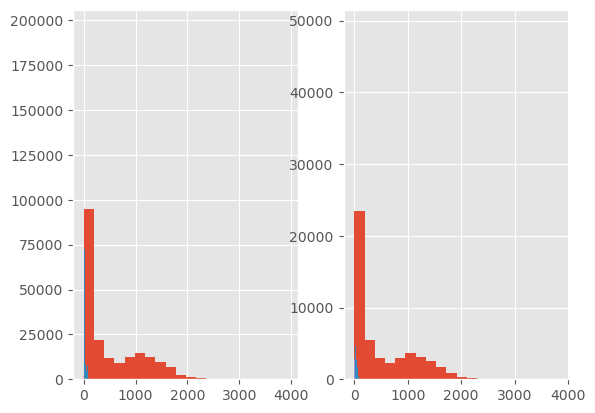

In [15]:
# reformat data
xtrain=np.array(X_train).copy().astype(np.float32)
xtest=np.array(X_test).copy().astype(np.float32)
for i in [0,13,16]:
    xtrain[:,i]=np.log(xtrain[:,i])
    xtest[:,i]=np.log(xtest[:,i])

for i in [0,13,14,15,16]:
    s=np.std(xtrain[:,i])
    xtrain[:,0]/=s
    xtest[:,0]/=s
    
plt.subplot(1,2,1)
for i in range(17):plt.hist(xtrain[:,i], 20);
plt.subplot(1,2,2)
for i in range(17):plt.hist(xtest[:,i], 20);

In [16]:
yt=np.array(Y_train).copy()
ytrain=np.zeros((len(yt),5), dtype=np.float32)
ytrain[np.arange(len(yt)), yt]=1
np.sum(ytrain, axis=0)

array([ 1508., 83853., 51136., 57895.,  3264.], dtype=float32)

In [17]:
# model tuning
model = tf.keras.models.Sequential()
model.add(keras.layers.Input(shape=(17,)))
l1l2=keras.regularizers.L1L2(l1=1e-5, l2=1e-4)
ini=keras.initializers.RandomNormal(stddev=1e-3)
model.add(keras.layers.Dense(128, activation = 'relu',kernel_initializer=ini, kernel_regularizer=l1l2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(128, activation = 'relu',kernel_initializer=ini, kernel_regularizer=l1l2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(128, activation = 'relu',kernel_initializer=ini, kernel_regularizer=l1l2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(.4))
model.add(keras.layers.Dense(5, activation = 'softmax',kernel_initializer=ini, kernel_regularizer=l1l2))


loss = keras.losses.SparseCategoricalCrossentropy()
# loss = keras.losses.MeanSquaredError()
optim = keras.optimizers.Adam(learning_rate = 1e-5)
metrics = []

model.compile(loss = loss, optimizer = optim, metrics = metrics)
nn_model=model
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2304      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [18]:
# NN model fitting
# nn_model = tuner.hypermodel.build(best_hps) # Model Training
history = nn_model.fit(xtrain, Y_train, epochs = 20, validation_split = 0.2)
# history = nn_model.fit(X_train, Y_train, epochs = 10, validation_split = 0.2)

Epoch 1/20
4942/4942 [==============================] - 10s 2ms/step - loss: 0.7300 - val_loss: 1.3408
Epoch 2/20
4942/4942 [==============================] - 8s 2ms/step - loss: 0.4488 - val_loss: 1.2377
Epoch 3/20
4942/4942 [==============================] - 9s 2ms/step - loss: 0.3837 - val_loss: 1.1534
Epoch 4/20
4942/4942 [==============================] - 9s 2ms/step - loss: 0.3535 - val_loss: 1.2446
Epoch 5/20
4942/4942 [==============================] - 9s 2ms/step - loss: 0.3391 - val_loss: 1.2063
Epoch 6/20
4942/4942 [==============================] - 9s 2ms/step - loss: 0.3263 - val_loss: 1.1538
Epoch 7/20
4942/4942 [==============================] - 9s 2ms/step - loss: 0.3202 - val_loss: 1.1742
Epoch 8/20
4942/4942 [==============================] - 9s 2ms/step - loss: 0.3109 - val_loss: 1.2779
Epoch 9/20
4942/4942 [==============================] - 9s 2ms/step - loss: 0.3038 - val_loss: 1.0373
Epoch 10/20
4942/4942 [==============================] - 9s 2ms/step - loss: 0.29

In [19]:
# NN predict
nn_predictions = nn_model.predict(xtrain)
print(np.sum(nn_predictions, axis=0).astype(int))
print(np.unique(Y_train, return_counts=True))


6177/6177 [==============================] - 4s 681us/step
[   121 103735  51790  38632   3377]
(array([0, 1, 2, 3, 4]), array([ 1508, 83853, 51136, 57895,  3264]))


In [20]:
# NN model performance
from sklearn import metrics

# Predictions
nn_predictions = nn_model.predict(xtest)

# Evaluation
# nn_model.evaluate(X_test, Y_test, verbose = 2)

# nn_converted_predictions_arr = convertToMode(nn_predictions)
nn_converted_predictions_arr = nn_predictions.argmax(axis=1)
nn_accuracy = metrics.accuracy_score(Y_test, nn_converted_predictions_arr)

print("Overall Neural Network Accuracy: ", nn_accuracy)

# for x in range(0, 5):
#     printIsolatedAccuracy(Y_test_reset, x, np.array(nn_converted_predictions_arr), "Neural Network")
    
conf_matrix = confusion_matrix(Y_test, nn_converted_predictions_arr)   
print(conf_matrix)

# overall accuracy report
print(classification_report(Y_test, nn_converted_predictions_arr))

1545/1545 [==============================] - 1s 713us/step
Overall Neural Network Accuracy:  0.794402735900601
[[    0     7   370     1     0]
 [    0 20171     2   791     0]
 [    0   259 12506     0    20]
 [    0  8683     0  5791     0]
 [    0     0    27     0   789]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       378
           1       0.69      0.96      0.81     20964
           2       0.97      0.98      0.97     12785
           3       0.88      0.40      0.55     14474
           4       0.98      0.97      0.97       816

    accuracy                           0.79     49417
   macro avg       0.70      0.66      0.66     49417
weighted avg       0.82      0.79      0.77     49417



# generate SHAP comparison

In [13]:
# random forest
rf_explainer = shap.TreeExplainer(random_forest_tuned, 
                                  feature_perturbation="tree_path_dependent")
rf_shap_values = rf_explainer.shap_values(X_test, approximate = True) 
print('rf shap done')
# xgboost
xgb_explainer = shap.TreeExplainer(xgb_model_tuned, 
                                   feature_perturbation="tree_path_dependent")
xgb_shap_values = xgb_explainer.shap_values(X_test) 
print('xgb shap done')

# catboost
X_test_reduced = X_test.sample(frac=0.1, replace=False)
print(len(X_test_reduced))
cb_explainer = shap.TreeExplainer(catboost_model_tuned, 
                                  feature_perturbation="tree_path_dependent")
cb_shap_values = cb_explainer.shap_values(X_test_reduced) 
print('catboost shap done')

# neural network --> dropped due to low performance
# xtest_reduced = xtest[0:100,:]
# nn_explainer = shap.KernelExplainer(nn_model.predict, shap.sample(xtest, 100)) 
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     nn_shap_values = nn_explainer.shap_values(xtest_reduced, nsamples = 15)
# print('NN shap done')    


rf shap done
xgb shap done
4942
catboost shap done


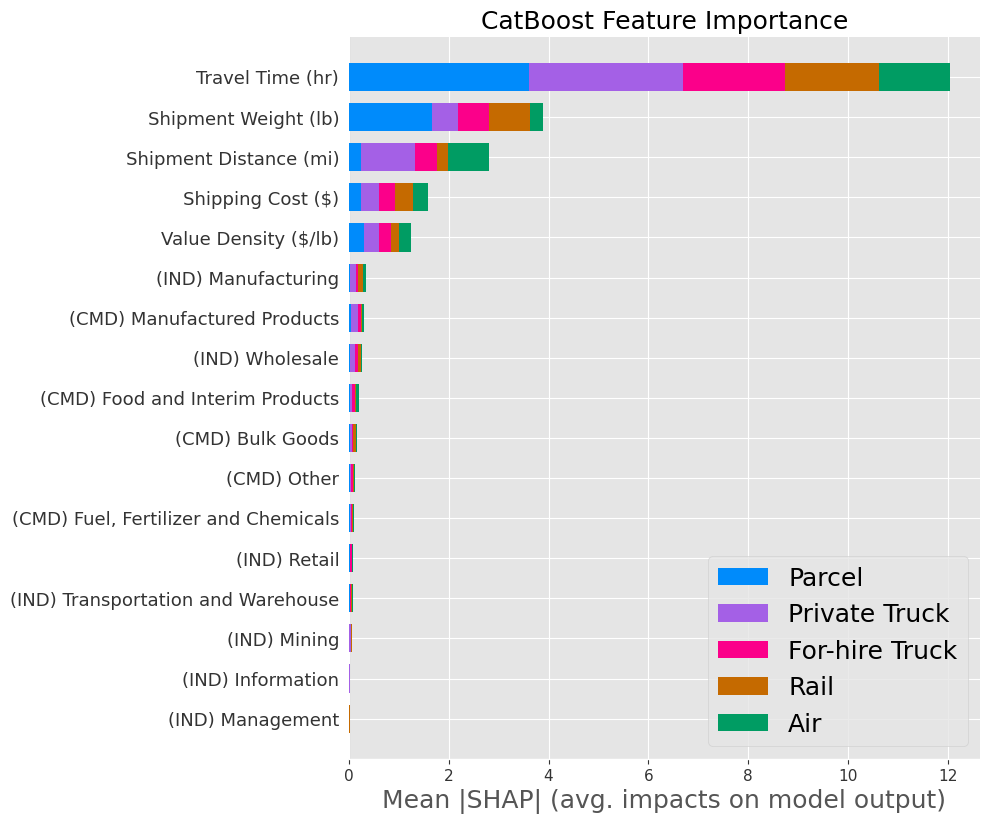

In [14]:
# feature importance (all mode)

# random forest
# plt.figure(figsize = (4.5, 6))
# shap.summary_plot(rf_shap_values, X_test, class_names = labels, 
#                   feature_names = features, show = False, plot_size = (8,10))
# plt.legend(loc = 'lower right', fontsize = 12)
# plt.title('Random forest')
# plt.savefig('plot/random_forest_feature_importance.jpg', 
#             dpi = 300, bbox_inches = 'tight')
# plt.show()

# # xgboost
# # plt.figure(figsize = (4.5, 6))
# shap.summary_plot(xgb_shap_values, X_test, class_names = labels, 
#                   feature_names = features, show = False, plot_size = (8,10))
# plt.legend(loc = 'lower right', fontsize = 12)
# plt.title('XGBoost')
# plt.savefig('plot/xgboost_feature_importance.jpg', 
#             dpi = 300, bbox_inches = 'tight')
# plt.show()
#catboost
# plt.figure(figsize = (4.5, 6))
shap.summary_plot(cb_shap_values, X_test_reduced, class_names = labels, 
                  feature_names = features, show = False, plot_size = (10,8))
plt.legend(loc = 'lower right', fontsize = 18)
plt.title('CatBoost Feature Importance', fontsize = 18)
plt.xlabel('Mean |SHAP| (avg. impacts on model output)', fontsize = 18)
plt.savefig('plot/catboost_feature_importance.jpg', 
            dpi = 300, bbox_inches = 'tight')
plt.show()

# neural network
# shap.summary_plot(nn_shap_values, xtest_reduced, class_names = labels, 
#                   feature_names = features, show = False)
# plt.legend(loc = 'lower right', fontsize = 12)
# plt.title('Neural Network')
# plt.savefig('plot/neural_network_feature_importance.png', dpi = 200)
# plt.show()

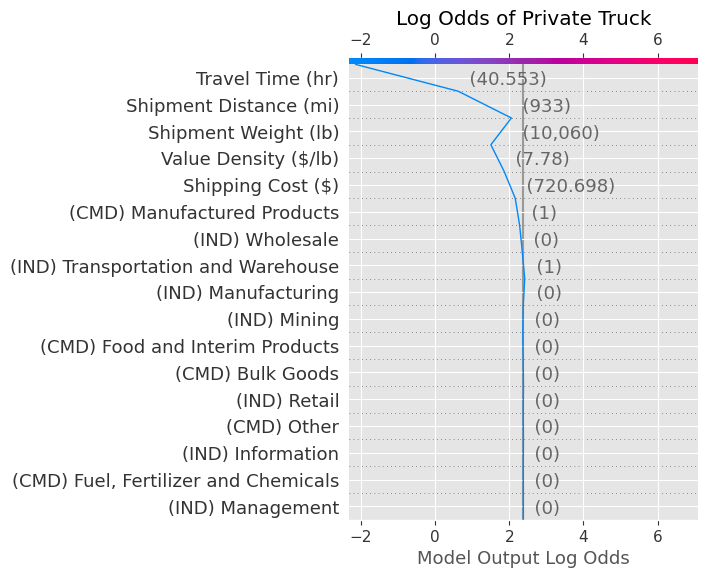

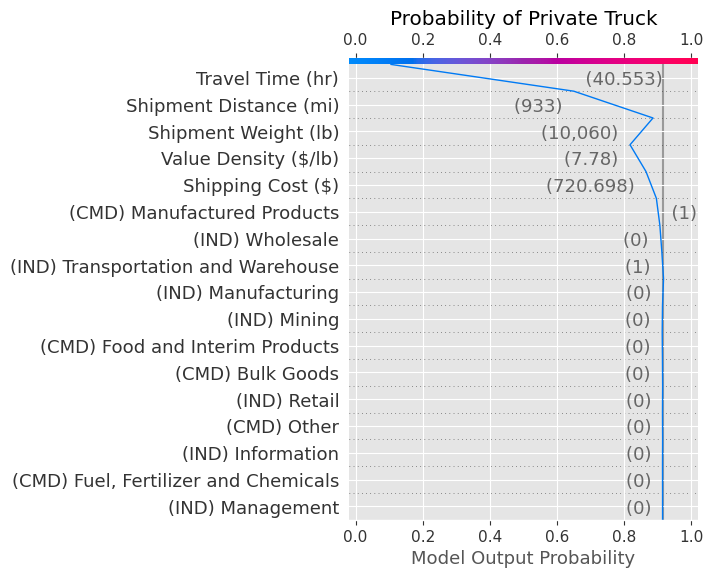

In [45]:
# plot the first sentence's explanation
i=20
plt.figure(figsize = (4.5, 6))
shap.decision_plot(cb_explainer.expected_value[3], 
                cb_shap_values[3][i], 
                X_test_reduced.values[i], 
                feature_names = features, show=False, auto_size_plot = False)
f = plt.gcf()
plt.xlabel('Model Output Log Odds')
plt.title('Log Odds of Private Truck')
plt.savefig('plot/sample_private_truck_interpretation.png', 
            dpi = 300, bbox_inches = 'tight')
plt.show()

i=20
plt.figure(figsize = (4.5, 6))
shap.decision_plot(cb_explainer.expected_value[3], 
                cb_shap_values[3][i], 
                X_test_reduced.values[i], 
                feature_names = features, link="logit", show=False, 
                   auto_size_plot = False)
f = plt.gcf()
plt.xlabel('Model Output Probability')
plt.title('Probability of Private Truck')
plt.savefig('plot/sample_private_truck_interpretation_prob.png', 
            dpi = 300, bbox_inches = 'tight')
plt.show()

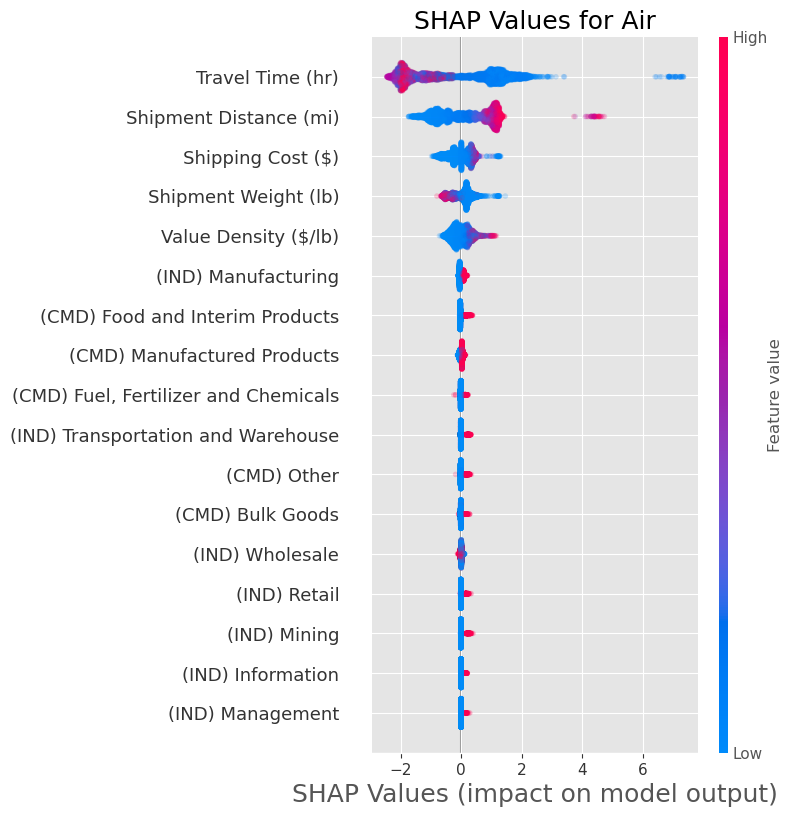

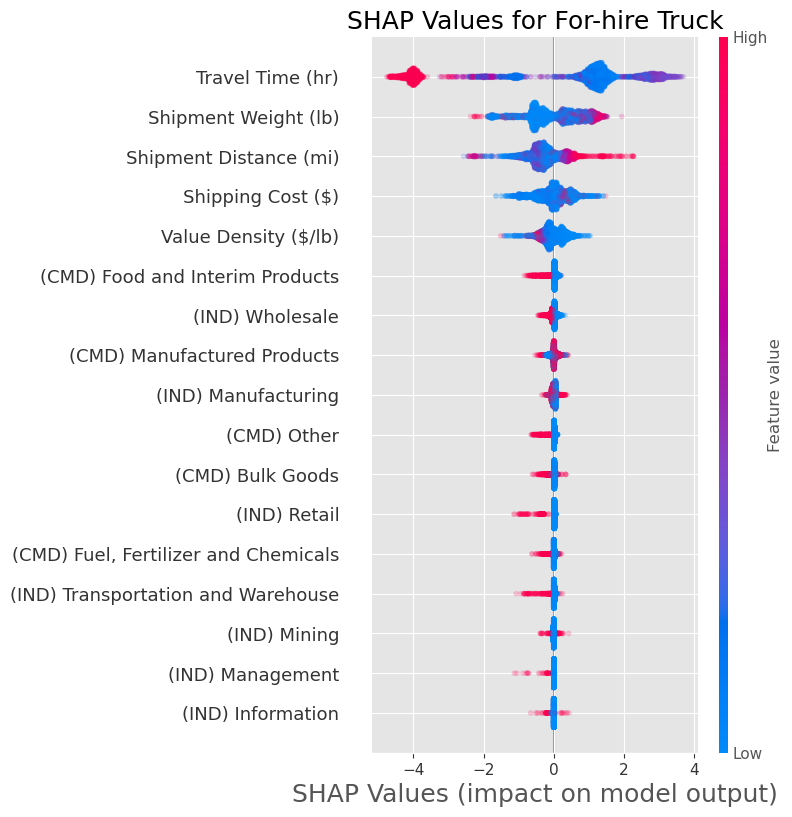

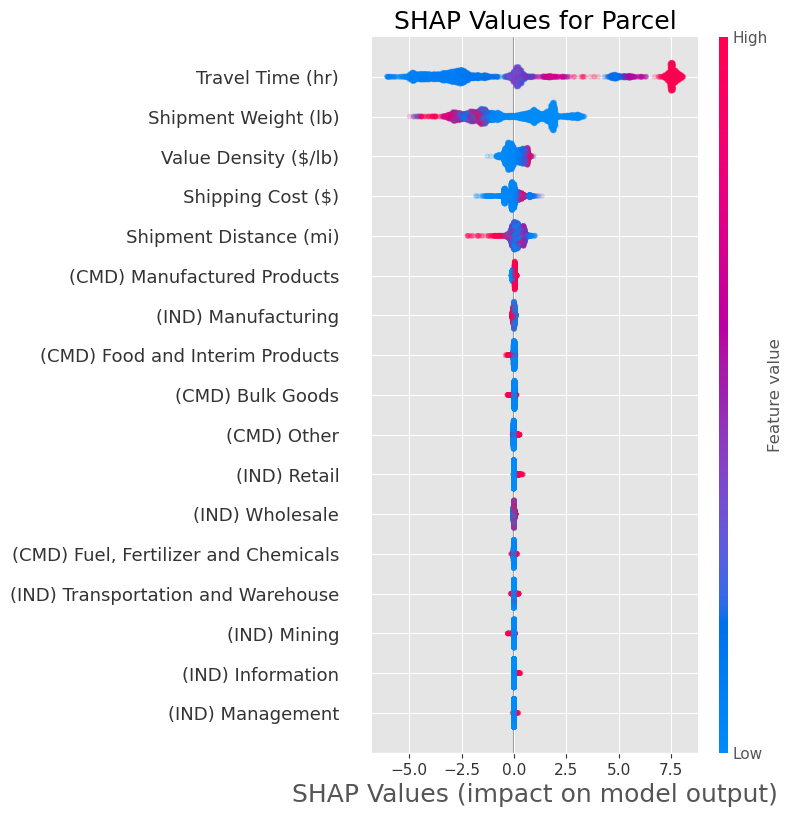

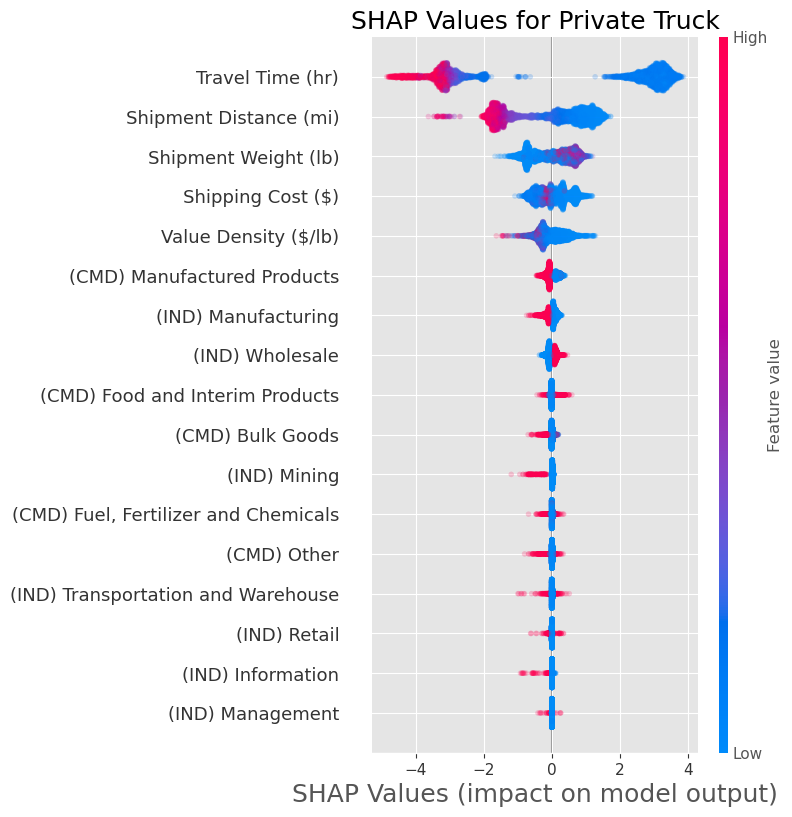

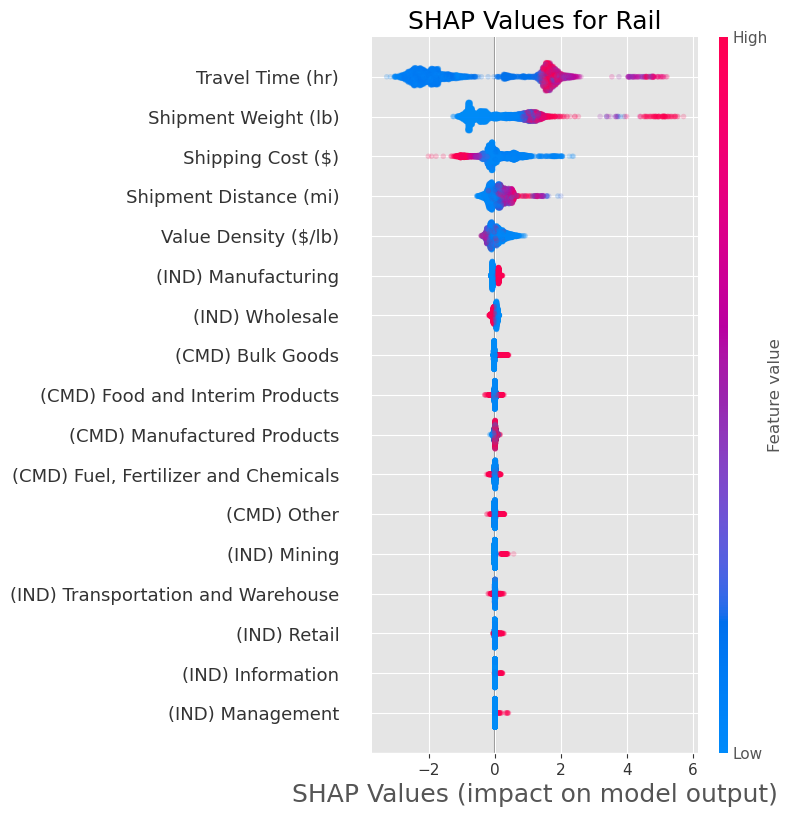

In [15]:
# plot by mode (catboost)
# labels = ['Air', 'For-hire Truck', 'Parcel', 'Private Truck', 'Rail']
shap.summary_plot(cb_shap_values[0], X_test_reduced, alpha = 0.2, 
                  class_names = labels, show=False, feature_names = features, 
                  plot_size = (8,8))
plt.title('SHAP Values for Air', fontsize = 18)
plt.xlabel('SHAP Values (impact on model output)', fontsize = 18)
plt.savefig('plot/catboost_air_feature_ranking.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

shap.summary_plot(cb_shap_values[1], X_test_reduced, alpha = 0.2, 
                  class_names = labels, show=False, feature_names = features, 
                  plot_size = (8,8))
plt.title('SHAP Values for For-hire Truck', fontsize = 18)
plt.xlabel('SHAP Values (impact on model output)', fontsize = 18)
plt.savefig('plot/catboost_for-hire_truck_feature_ranking.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

shap.summary_plot(cb_shap_values[2], X_test_reduced, alpha = 0.2, 
                  class_names = labels, show=False, feature_names = features, 
                  plot_size = (8,8))
plt.title('SHAP Values for Parcel', fontsize = 18)
plt.xlabel('SHAP Values (impact on model output)', fontsize = 18)
plt.savefig('plot/catboost_parcel_feature_ranking.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

shap.summary_plot(cb_shap_values[3], X_test_reduced, alpha = 0.2, 
                  class_names = labels, show=False, feature_names = features, 
                  plot_size = (8,8))
plt.title('SHAP Values for Private Truck', fontsize = 18)
plt.xlabel('SHAP Values (impact on model output)', fontsize = 18)
plt.savefig('plot/catboost_private_truck_feature_ranking.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

shap.summary_plot(cb_shap_values[4], X_test_reduced, alpha = 0.2, 
                  class_names = labels, show=False, feature_names = features, 
                  plot_size = (8,8))
plt.title('SHAP Values for Rail', fontsize = 18)
plt.xlabel('SHAP Values (impact on model output)', fontsize = 18)
plt.savefig('plot/catboost_rail_feature_ranking.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

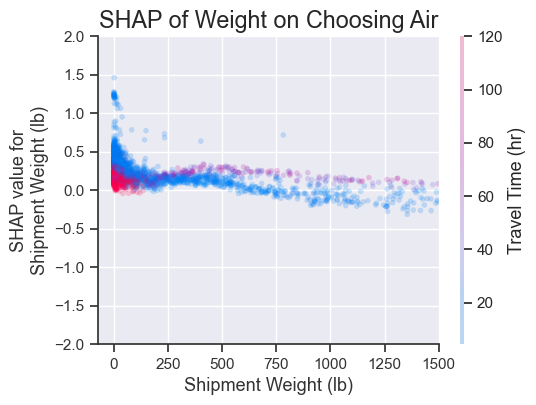

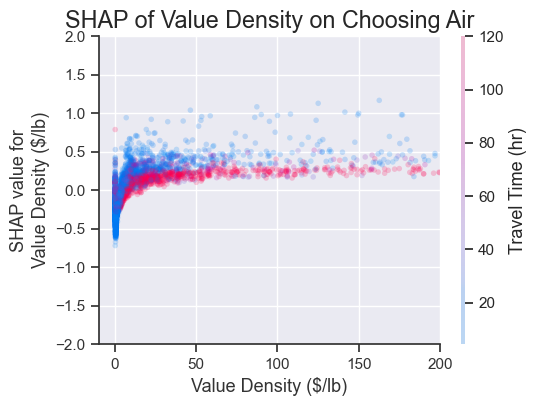

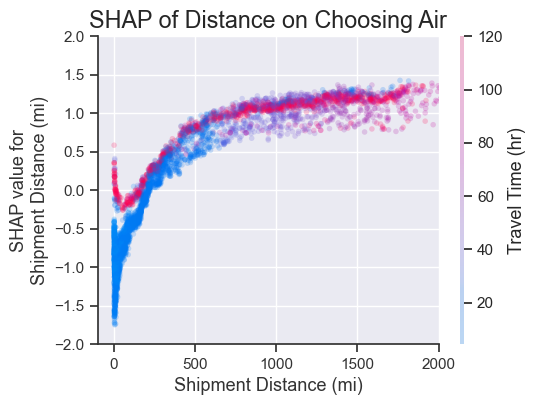

In [19]:
#air mode

#weight
# plt.figure(figsize = (4,5))
sns.set(font_scale=1.4)  # larger font
shap.dependence_plot(0, cb_shap_values[0], X_test_reduced, 
                     interaction_index = 'auto',
                     alpha = 0.2, feature_names = features, 
                     show=False, xmax = 1500)
plt.ylim([-2, 2])
plt.gcf().set_size_inches(5.5,4)
plt.title('SHAP of Weight on Choosing Air')
plt.savefig('plot/catboost_air_weight.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

# value density
shap.dependence_plot(13, cb_shap_values[0], X_test_reduced, 
                     interaction_index = 'auto', 
                     alpha = 0.2, feature_names = features, 
                     show=False, xmax = 200)
plt.ylim([-2, 2])
plt.title('SHAP of Value Density on Choosing Air')
plt.gcf().set_size_inches(5.5,4)
plt.savefig('plot/catboost_air_valden.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

# travel distance
shap.dependence_plot(14, cb_shap_values[0], X_test_reduced, 
                     interaction_index = 'auto',
                     alpha = 0.2, feature_names = features, 
                     show=False, xmax = 2000)
plt.ylim([-2, 2])
plt.title('SHAP of Distance on Choosing Air')
plt.gcf().set_size_inches(5.5,4)
plt.savefig('plot/catboost_air_distance.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

# time
# shap.dependence_plot(15, cb_shap_values[0], X_test_reduced, 
#                      interaction_index = 'auto', 
#                      alpha = 0.2, feature_names = features, 
#                      show=False, xmax = 100)
# plt.ylim([-2, 6])
# plt.savefig('plot/catboost_air_time.jpg', dpi = 300)
# plt.show()

# # cost
# shap.dependence_plot(16, cb_shap_values[0], X_test_reduced, 
#                      interaction_index = 'auto', 
#                      alpha = 0.2, feature_names = features, 
#                      show=False, xmax = 1500)
# plt.ylim([-2, 6])
# plt.savefig('plot/catboost_air_cost.jpg', dpi = 300)
# plt.show()

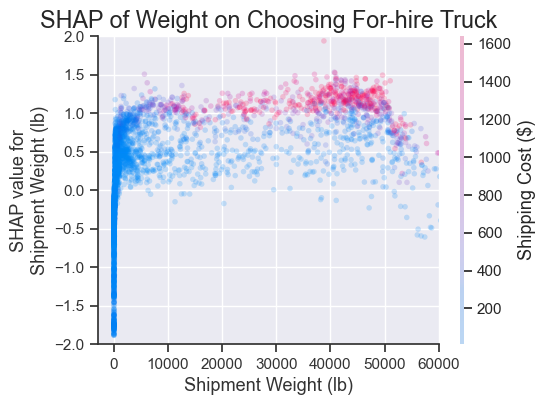

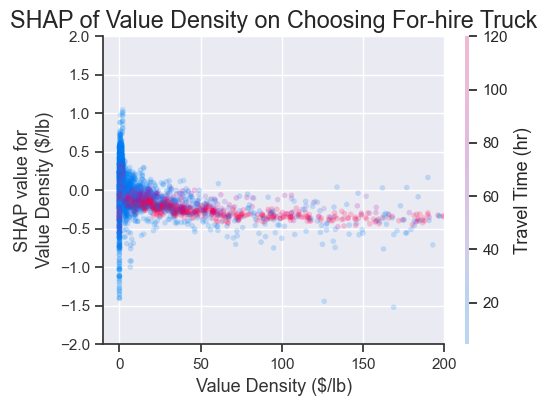

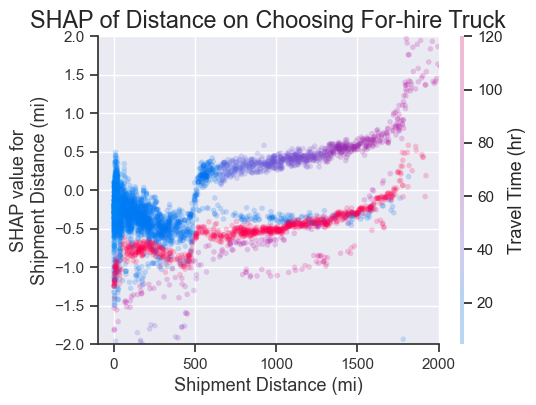

In [20]:
# customize plot - for-hire truck

# weight

shap.dependence_plot(0, cb_shap_values[1], X_test_reduced, 
                     interaction_index = 'auto',
                     alpha = 0.2, feature_names = features, show=False, 
                     xmax = 60000)
plt.ylim([-2, 2])
plt.title('SHAP of Weight on Choosing For-hire Truck')
plt.gcf().set_size_inches(5.5,4)
plt.savefig('plot/catboost_for_hire_truck_weight.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

# value density
shap.dependence_plot(13, cb_shap_values[1], X_test_reduced, interaction_index = 'auto', 
                     alpha = 0.2, feature_names = features, 
                     show=False, xmax = 200)
plt.ylim([-2, 2])
plt.title('SHAP of Value Density on Choosing For-hire Truck')
plt.gcf().set_size_inches(5.5,4)
plt.savefig('plot/catboost_for_hire_truck_valden.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

# travel distance
shap.dependence_plot(14, cb_shap_values[1], X_test_reduced, interaction_index = 'auto',
                     alpha = 0.2, feature_names = features, 
                     show=False, xmax = 2000)
plt.ylim([-2, 2])
plt.title('SHAP of Distance on Choosing For-hire Truck')
plt.gcf().set_size_inches(5.5,4)
plt.savefig('plot/catboost_for_hire_truck_distance.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

# time
# shap.dependence_plot(15, cb_shap_values[1], X_test_reduced, interaction_index = 'auto', 
#                      alpha = 0.2, feature_names = features, 
#                      show=False, xmax = 100)
# plt.savefig('plot/catboost_for_hire_truck_time.jpg', dpi = 300)
# plt.show()

# # cost
# shap.dependence_plot(16, cb_shap_values[1], X_test_reduced, interaction_index = 'auto', 
#                      alpha = 0.2, feature_names = features, 
#                      show=False, xmax = 1500)
# plt.savefig('plot/catboost_for_hire_truck_cost.jpg', dpi = 300)
# plt.show()

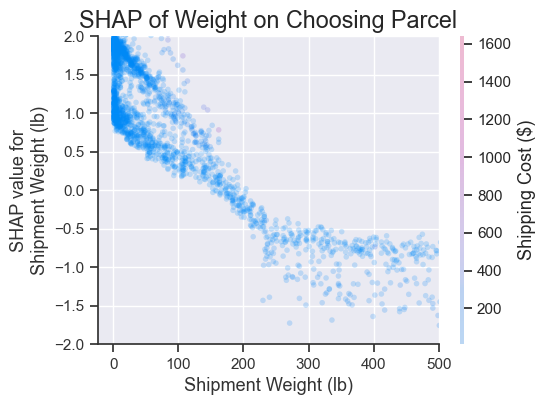

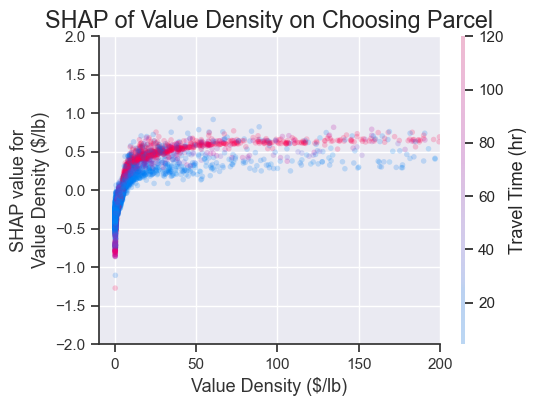

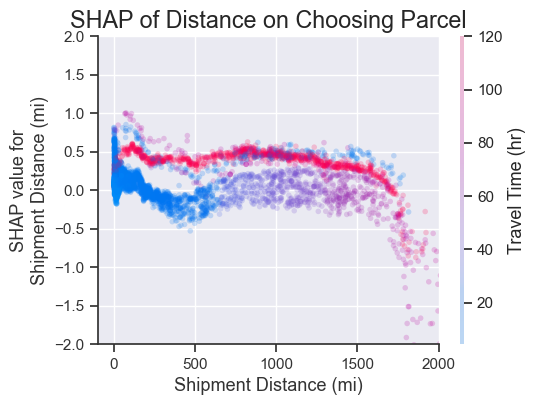

In [21]:
# customize plot - parcel

#weight
shap.dependence_plot(0, cb_shap_values[2], X_test_reduced, 
                     interaction_index = 'auto',
                     alpha = 0.2, feature_names = features, 
                     show=False, xmax = 500)
plt.ylim([-2, 2])
plt.title('SHAP of Weight on Choosing Parcel')
plt.gcf().set_size_inches(5.5,4)
plt.savefig('plot/catboost_parcel_weight.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

# value density
shap.dependence_plot(13, cb_shap_values[2], X_test_reduced, interaction_index = 'auto', 
                     alpha = 0.2, feature_names = features, 
                     show=False, xmax = 200)
plt.ylim([-2, 2])
plt.title('SHAP of Value Density on Choosing Parcel')
plt.gcf().set_size_inches(5.5,4)
plt.savefig('plot/catboost_parcel_valden.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

# travel distance
shap.dependence_plot(14, cb_shap_values[2], X_test_reduced, 
                     interaction_index = 'auto',
                     # interaction_index = 'Shipping Cost ($)',
                     alpha = 0.2, feature_names = features, 
                     show=False, xmax = 2000)
plt.ylim([-2, 2])
plt.title('SHAP of Distance on Choosing Parcel')
plt.gcf().set_size_inches(5.5,4)
plt.savefig('plot/catboost_parcel_distance.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

# # time
# shap.dependence_plot(15, cb_shap_values[2], X_test_reduced, interaction_index = 'auto', 
#                      alpha = 0.2, feature_names = features, 
#                      show=False, xmax = 100)
# plt.savefig('plot/catboost_parcel_time.jpg', dpi = 300)
# plt.show()

# # cost
# shap.dependence_plot(16, cb_shap_values[2], X_test_reduced, interaction_index = 'auto', 
#                      alpha = 0.2, feature_names = features, 
#                      show=False, xmax = 1500)
# plt.savefig('plot/catboost_parcel_cost.jpg', dpi = 300)
# plt.show()

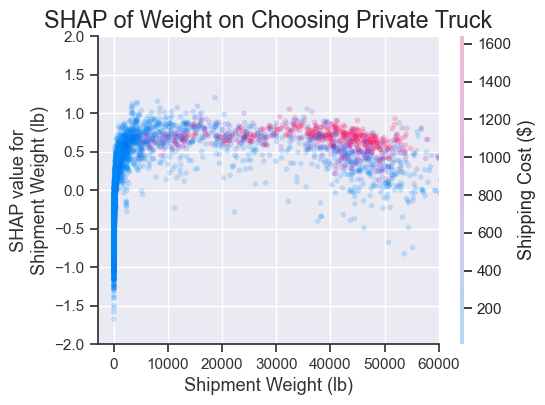

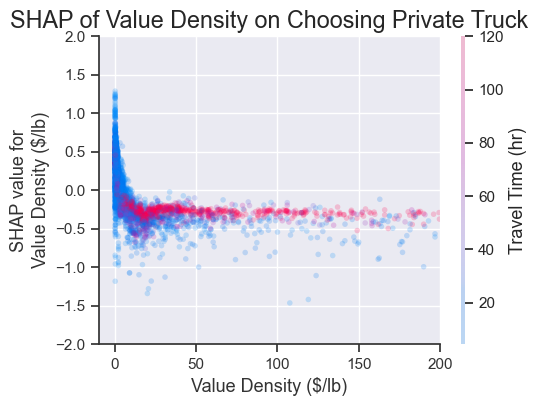

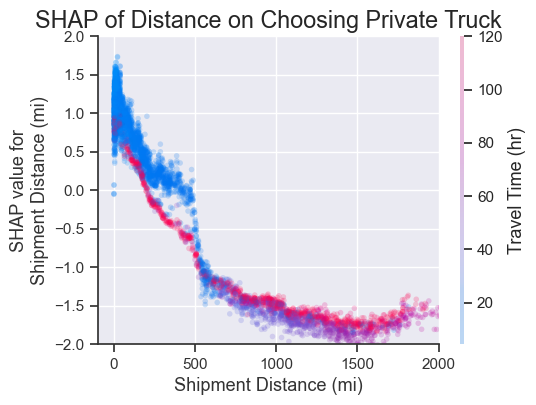

In [22]:
# customize plot - private truck

# weight

shap.dependence_plot(0, cb_shap_values[3], X_test_reduced, 
                     interaction_index = 'auto',
                     alpha = 0.2, feature_names = features, 
                     show=False, xmax = 60000)
plt.ylim([-2, 2])
plt.title('SHAP of Weight on Choosing Private Truck')
plt.gcf().set_size_inches(5.5,4)
plt.savefig('plot/catboost_private_truck_weight.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

# value density
shap.dependence_plot(13, cb_shap_values[3], X_test_reduced, 
                     interaction_index = 'auto', 
                     alpha = 0.2, feature_names = features, 
                     show=False, xmax = 200)
plt.ylim([-2, 2])
plt.title('SHAP of Value Density on Choosing Private Truck')
plt.gcf().set_size_inches(5.5,4)
plt.savefig('plot/catboost_private_truck_valden.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

# travel distance
shap.dependence_plot(14, cb_shap_values[3], X_test_reduced, 
                     interaction_index = 'auto',
                     alpha = 0.2, feature_names = features, 
                     show=False, xmax = 2000)
plt.ylim([-2, 2])
plt.title('SHAP of Distance on Choosing Private Truck')
plt.gcf().set_size_inches(5.5,4)
plt.savefig('plot/catboost_private_truck_distance.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

# time
# shap.dependence_plot(15, cb_shap_values[1], X_test_reduced, 
#                      interaction_index = 'auto', 
#                      alpha = 0.2, feature_names = features, 
#                      show=False, xmax = 100)
# plt.savefig('plot/catboost_private_truck_time.jpg', dpi = 300)
# plt.show()

# # cost
# shap.dependence_plot(16, cb_shap_values[3], X_test_reduced, 
#                      interaction_index = 'auto', 
#                      alpha = 0.2, feature_names = features, 
#                      show=False, xmax = 1500)
# plt.savefig('plot/catboost_private_truck_cost.jpg', dpi = 300)
# plt.show()

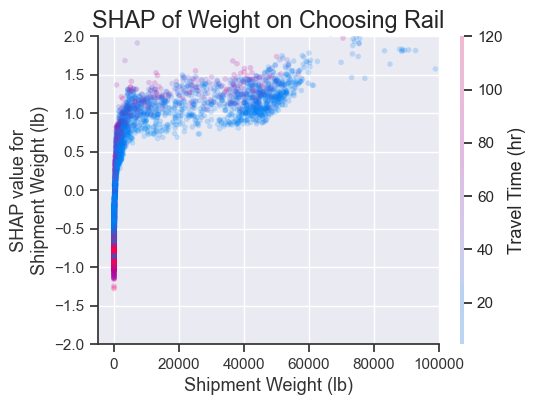

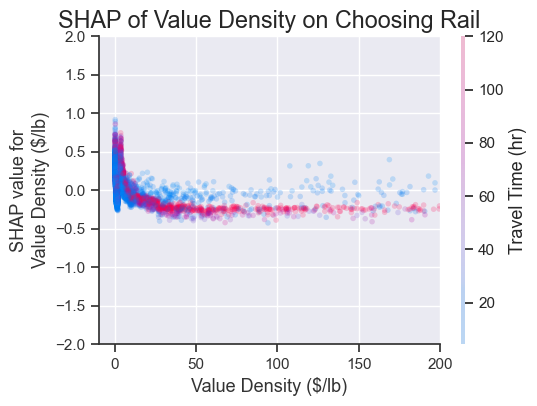

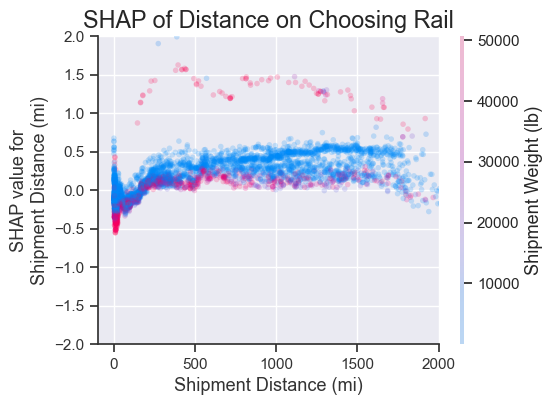

In [23]:
# customize plot - rail 

# weight

shap.dependence_plot(0, cb_shap_values[4], X_test_reduced, 
                     interaction_index = 'auto',
                     alpha = 0.2, feature_names = features, 
                     show=False, xmax = 100000)
plt.ylim([-2, 2])
plt.title('SHAP of Weight on Choosing Rail')
plt.gcf().set_size_inches(5.5,4)
plt.savefig('plot/catboost_rail_weight.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

# value density
shap.dependence_plot(13, cb_shap_values[4], X_test_reduced, 
                     interaction_index = 'auto', 
                     alpha = 0.2, feature_names = features, 
                     show=False, xmax = 200)
plt.ylim([-2, 2])
plt.title('SHAP of Value Density on Choosing Rail')
plt.gcf().set_size_inches(5.5,4)
plt.savefig('plot/catboost_rail_valden.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

# travel distance
shap.dependence_plot(14, cb_shap_values[4], X_test_reduced, 
                     interaction_index = 'auto',
                     alpha = 0.2, feature_names = features, 
                     show=False, xmax = 2000)
plt.ylim([-2, 2])
plt.title('SHAP of Distance on Choosing Rail')
plt.gcf().set_size_inches(5.5,4)
plt.savefig('plot/catboost_rail_distance.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

# time
# shap.dependence_plot(15, cb_shap_values[4], X_test_reduced, 
#                      interaction_index = 'auto', 
#                      alpha = 0.2, feature_names = features, 
#                      show=False, xmax = 100)
# plt.savefig('plot/catboost_rail_time.jpg', dpi = 300)
# plt.show()

# # cost
# shap.dependence_plot(16, cb_shap_values[4], X_test_reduced, 
#                      interaction_index = 'auto', 
#                      alpha = 0.2, feature_names = features, 
#                      show=False, xmax = 1500)
# plt.savefig('plot/catboost_rail_cost.jpg', dpi = 300)
# plt.show()